<a href="https://colab.research.google.com/github/BrunoReis136/tensorflow/blob/main/TensorFlowTTSadvanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> TTS -  DOWNLOAD DO DATASET LJSPEECH </h1>

In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar xvjf LJSpeech-1.1.tar.bz2
#download LJSpeech-1.1  dataset de TTS

<h2>CONVERTER ARQUIVOS DE ÁUDIO PARA PADRÕES RATE/CHANNEL/WIDTH</h2>

In [2]:
!pip install pydub

In [3]:
from pydub import AudioSegment
import os
from tqdm import tqdm

input_dir = "LJSpeech-1.1/wavs"
output_dir = "LJSpeech-1.1/wavs16k"

for filename in tqdm(os.listdir(input_dir)):
  if filename.endswith(".wav"):
    filepath = os.path.join(input_dir, filename)
    audio = AudioSegment.from_wav(filepath)

    audio = audio.set_frame_rate(16000).set_channels(1).set_sample_width(2)

    output_path = os.path.join(output_dir, filename)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    audio.export(output_path, format="wav")

100%|██████████| 13100/13100 [01:01<00:00, 213.58it/s]


<h2>Dataframe dos metadatas e coluna com caminho dos arquivos</h2>

In [5]:
import pandas as pd

metadata = pd.read_csv('LJSpeech-1.1/metadata.csv',sep="|", header=None)
metadata.columns = ['file_id', 'text', 'normalized_text']
metadata['wav_path'] = metadata['file_id'].apply(lambda x:f'LJSpeech-1.1/wav16k/{x}.wav')

<h2>Extrair Mel com Librosa: FUNÇÃO</h2>

In [6]:
import os
import librosa
import numpy as np
from tqdm import tqdm

def convert_wav_to_mel(input_dir,
                       output_dir,
                       sr=16000,
                       n_fft=1024,
                       hop_length=256,
                       n_mels=80,
                       power=1.0,
                       to_db=True,
                       verbose=True):

    os.makedirs(output_dir, exist_ok=True)
    file_list = [f for f in os.listdir(input_dir) if f.endswith(".wav")]
    iterator = tqdm(file_list, desc="Convertendo WAV → Mel") if verbose else file_list

    for filename in iterator:
        filepath = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))

        y, _ = librosa.load(filepath, sr=sr)

        mel = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=power
        )

        if to_db:
            mel = librosa.power_to_db(mel, ref=np.max)

        np.save(output_path, mel)

<h2>Extrair Mel com Librosa: EXECUÇÃO</h2>

In [7]:
convert_wav_to_mel(
    input_dir="LJSpeech-1.1/wavs16k",
    output_dir="LJSpeech-1.1/mels"
)

Convertendo WAV → Mel: 100%|██████████| 13100/13100 [04:15<00:00, 51.31it/s]


<h2>Visualização do spectrograma (somente por diversão)</h2>

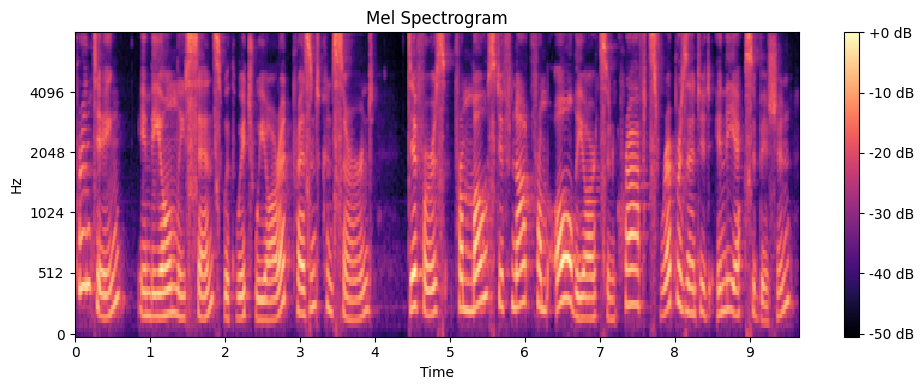

In [8]:
'''import matplotlib.pyplot as plt
import librosa.display

mel = np.load("LJSpeech-1.1/mels/LJ001-0001.npy")
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, sr=16000, hop_length=256, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()'''

<h2>Dados tabulares para Dataframe e Pré Processamento</h2>

In [22]:
import pandas as pd

df = pd.read_csv('LJSpeech-1.1/metadata.csv',
                       sep="|",
                       header=None,
                       names=['file_id', 'text', 'normalized_text'])

df['normalized_text'].fillna(df['text'],inplace=True)
df['normalized_text'].dropna(inplace=True)

# Incluir coluna 'mel_path'
df["mel_path"] = df["file_id"].apply(lambda x: f"LJSpeech-1.1/mels/{x}.npy")

/tmp/ipython-input-22-368791196.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['normalized_text'].fillna(df['text'],inplace=True)


<h2>Tokenizar textos por BPE(byte pair encoding): Função</h2>

In [10]:
import sentencepiece as spm
import os

def train_sentencepiece(
    texts,                 # lista de strings ou pd.Series com frases normalizadas
    input_txt_path='temp_text.txt',  # arquivo temporário para salvar as frases
    model_prefix='spm_model',        # prefixo do modelo e vocab
    vocab_size=200                   # tamanho do vocabulário
):
    # Salva os textos em um arquivo temporário
    with open(input_txt_path, 'w', encoding='utf-8') as f:
        for line in texts:
            f.write(line.strip() + '\n')

    # Treina o modelo SentencePiece
    spm.SentencePieceTrainer.Train(
        input=input_txt_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size
    )

    # (Opcional) Remove o arquivo temporário após treino
    if os.path.exists(input_txt_path):
        os.remove(input_txt_path)

    sp = spm.SentencePieceProcessor()
    sp.load(f'{model_prefix}.model' )

    # Adiciona ao DataFrame
    df["tokens_bpe"] = texts.apply(lambda t: sp.encode(t, out_type=int))

<h2>Tokenizar textos por BPE(byte pair encoding): Aplicação</h2>

In [11]:
train_sentencepiece(
    texts=df['normalized_text'],
    input_txt_path='temp_text.txt',
    model_prefix='spm_model',
    vocab_size=700
)

<h2>Salva o dataframe como arquivo picke(.pkl)</h2>

In [12]:
df.to_pickle('LJSpeech_preprocessed.pkl')

<h2>Cria classe Dataset para converter tokens/mels em tensores e retornar</h2>

In [13]:
import torch
from torch.utils.data import Dataset
import numpy as np

class TTSDataset(Dataset):
  def __init__(self, dataframe, pad_token=0, max_input_length=None, max_mel_length=None):
    self.df = dataframe
    self.pad_token = pad_token
    self.max_input_length = max_input_length
    self.max_mel_length = max_mel_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    tokens = row['tokens_bpe']
    mel_path = row['mel_path']
    # Carregar mel spec(.npy)
    mel = np.load(mel_path)
    #Converte em tensor
    tokens = torch.LongTensor(tokens)
    mel = torch.tensor(mel, dtype = torch.float32)

    return tokens, mel

<h2>Função de padding dinâmico ao carregar os dados no DataLoader</h2>

In [19]:
def tts_collate_fn(batch):
  input_seqs, mel_specs = zip(*batch)

  # Pad dos tokens
  input_lengths = [len(seq) for seq in  input_seqs]
  max_input_length = max(input_lengths)
  input_padded = torch.zeros(len(batch), max_input_length, dtype=torch.long)

  for i, seq in enumerate(input_seqs):
    input_padded[i, len(seq)] = seq

  #Pad dos mel specs (formato = [n_mel, T])
  mel_length = [mel.shape[1] for mel in mel_specs]
  max_mel_len = max(mel_length)
  n_mels = mel_specs[0].shape[0]
  mel_padded = torch.zeros(len(batch), n_mels, max_mel_len)

  for i, mel in enumerate(mel_specs):
    mel_padded[i, :, :mel_shape[1]] = mel

  return input_padded, torch.tensor(input_lengths), mel_padded, torch.tensor(mel_length)

<h2>Carregando dados com DataLoader</h2>


In [20]:
from torch.utils.data import DataLoader


# Carregando Dataframe com token_bpe e mel_path
# se necessário puxar o dataframe em df = pd.read_picke('LJSpeech_preprocessed')

dataset = TTSDataset(df)

loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=tts_collate_fn)

for batch in loader:
    input_ids, input_lengths, mel_specs, mel_lengths = batch
    print(input_ids.shape)      # [B, T_text]
    print(mel_specs.shape)      # [B, 80, T_mel]
    break

KeyError: 'mel_path'